
# ODE Mini-Project — Forward Euler

The goal of this notebook is to study the accuracy of the **Forward Euler method** for solving ordinary differential equations.  
Through implementation in Python, I explore how the step size affects numerical stability and global error, and verify that the method exhibits first-order convergence as predicted by theory.
 This notebook includes:
- The **math derivation** from Taylor expansion.
- A **clean implementation** of the solver.
- **Verification** against an exact solution.
- A **convergence test** showing first-order accuracy.
- Saved **figures** plus inline plots.

> Tip: Run cells in order. You can tweak parameters (like step size `h` or `lam`) and re-run to explore behavior.



## Math derivation (Forward Euler)

Given an initial value problem

$$
y'(t) = f(t, y), \quad y(t_0) = y_0,
$$

the Taylor expansion about $t_n$ gives

$$
y(t_n + h) = y(t_n) + h\,y'(t_n) + \mathcal O(h^2) = y_n + h f(t_n, y_n) + \mathcal O(h^2)
$$

Dropping the $\mathcal O(h^2)$ term yields the **Forward Euler** update:

$$
\boxed{ y_{n+1} = y_n + h\, f(t_n, y_n), \qquad t_{n+1} = t_n + h }
$$


In [7]:

# Imports and global parameters (feel free to modify lam, h, T)
import math
import numpy as np
import matplotlib.pyplot as plt

lam = 2.0   # lambda in y' = -lam*y
y0  = 1.0   # initial condition y(0) = 1
T   = 1.0   # final time
h   = 0.2   # step size (try 0.1, 0.05, etc.)


In [8]:

def f(t, y, lam=lam):
    """Right-hand side of the ODE: y' = -lam * y."""
    return -lam * y

def y_exact(t, lam=lam, y0=y0):
    """Exact solution: y(t) = y0 * exp(-lam * t)."""
    return y0 * math.exp(-lam * t)




## Implement one Euler step

Euler's update uses the slope at the beginning of the interval:

$$
y_{n+1} = y_n + h\, f(t_n, y_n)
$$

Below, `euler_step` advances one step; then we try a single step from $t_0 = 0$ to $t_1 = h$.



In [9]:

def euler_step(tn, yn, h):
    """One Forward Euler step: return (t_{n+1}, y_{n+1})."""
    slope = f(tn, yn)           # y'(t_n) = f(t_n, y_n)
    t_next = tn + h
    y_next = yn + h * slope
    return t_next, y_next

# Demonstration: one step from t0=0, y0=1
t0, y0_local = 0.0, y0
t1, y1 = euler_step(t0, y0_local, h)
print(f"After one Euler step with h={h}: t1={t1:.3f},  y1≈{y1:.6f},  exact y(h)={y_exact(h):.6f}") 


After one Euler step with h=0.2: t1=0.200,  y1≈0.600000,  exact y(h)=0.670320



## Solver loop

Advance steps until T, and record both the numerical and exact solutions to analyze error.


In [10]:

def euler_solve(f, t0, y0, h, T):
    """Solve y' = f(t,y) from t=t0 to T using Forward Euler with step size h."""
    N = int(round((T - t0) / h))
    t = np.empty(N + 1, dtype=float)
    y = np.empty(N + 1, dtype=float)
    t[0], y[0] = t0, y0
    for n in range(N):
        t[n+1], y[n+1] = euler_step(t[n], y[n], h)
    return t, y

# Run the solver and print a compact table
t, y_num = euler_solve(f, 0.0, y0, h, T)
y_true = np.array([y_exact(tt) for tt in t])
err = np.abs(y_num - y_true)

print("n   t_n      y_euler      y_exact     abs_error")
for n in range(len(t)):
    print(f"{n:2d}  {t[n]:6.3f}   {y_num[n]:10.6f}  {y_true[n]:10.6f}  {err[n]:10.6f}")

print(f"\nFinal: y(T) Euler = {y_num[-1]:.8f}, exact = {y_true[-1]:.8f}, abs error = {abs(y_num[-1]-y_true[-1]):.8f}")


n   t_n      y_euler      y_exact     abs_error
 0   0.000     1.000000    1.000000    0.000000
 1   0.200     0.600000    0.670320    0.070320
 2   0.400     0.360000    0.449329    0.089329
 3   0.600     0.216000    0.301194    0.085194
 4   0.800     0.129600    0.201897    0.072297
 5   1.000     0.077760    0.135335    0.057575

Final: y(T) Euler = 0.07776000, exact = 0.13533528, abs error = 0.05757528



## Plot: numerical vs exact solution

This reveals the global error visually. Try reducing `h` (e.g., 0.1, 0.05) and rerun.


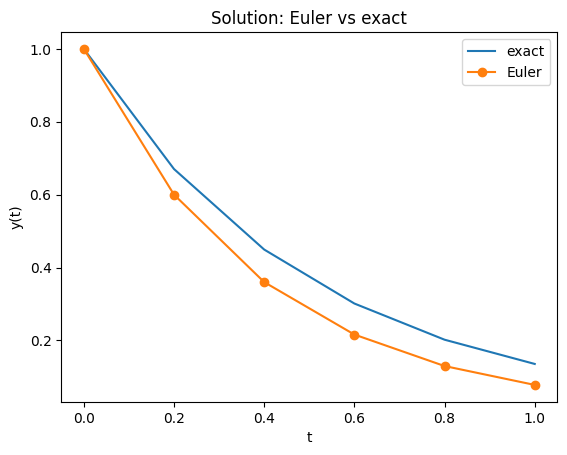

In [11]:

plt.figure()
plt.plot(t, y_true, label="exact")
plt.plot(t, y_num, 'o-', label="Euler")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.title("Solution: Euler vs exact"); plt.legend()
plt.show()



## Convergence study (order verification)

For a first-order method, halving h should roughly halve the error at a fixed time T.  
We’ll compute the absolute error at T for a list of step sizes and plot on a log–log scale; the slope should be close to 1.


h        |error(T)|
 0.4000  0.09533528
 0.2000  0.05757528
 0.1000  0.02796110
 0.0500  0.01375863
 0.0250  0.00682313


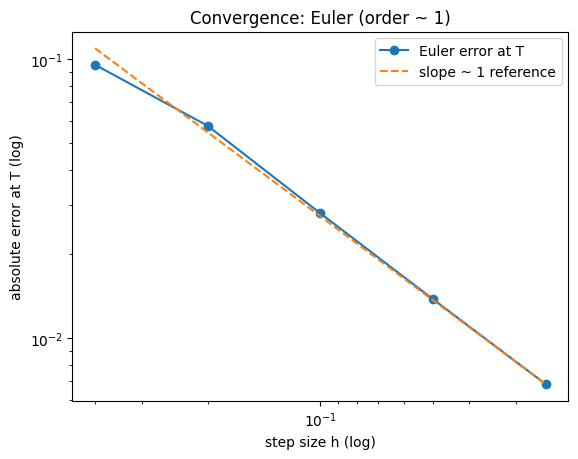

In [12]:

def final_error_for_h(h_value):
    t_, y_ = euler_solve(f, 0.0, y0, h_value, T)
    return abs(y_[-1] - y_exact(T))

hs = [0.4, 0.2, 0.1, 0.05, 0.025]
errors = [final_error_for_h(hh) for hh in hs]
print("h        |error(T)|")
for hh, ee in zip(hs, errors):
    print(f"{hh:7.4f}  {ee:.8f}")

plt.figure()
plt.loglog(hs, errors, 'o-', label="Euler error at T")
c = errors[-1]/hs[-1]
ref = [c*hh for hh in hs]
plt.loglog(hs, ref, '--', label="slope ~ 1 reference")
plt.gca().invert_xaxis()
plt.xlabel("step size h (log)"); plt.ylabel("absolute error at T (log)")
plt.title("Convergence: Euler (order ~ 1)"); plt.legend()
plt.show()



## Stability (for the test problem)


For the ODE $y' = -\lambda y$, the Euler update has factor:

$$
a = 1 - \lambda h
$$

Stability demands:

$$
|a| < 1 \; \iff \; 0 < h < \frac{2}{\lambda}
$$

Experiment by changing `lam` and `h` above and re-running the solver cell.


